In [1]:
!pip install mplfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.layers import RepeatVector
from keras.optimizers import Nadam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv',sep=',')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.shape

(2035, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])


In [7]:
df['Date'].dtype

dtype('<M8[ns]')

In [8]:
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

We don`t have any missing value

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


# Visulaizing

**Line plot For Opening and Closing Price**

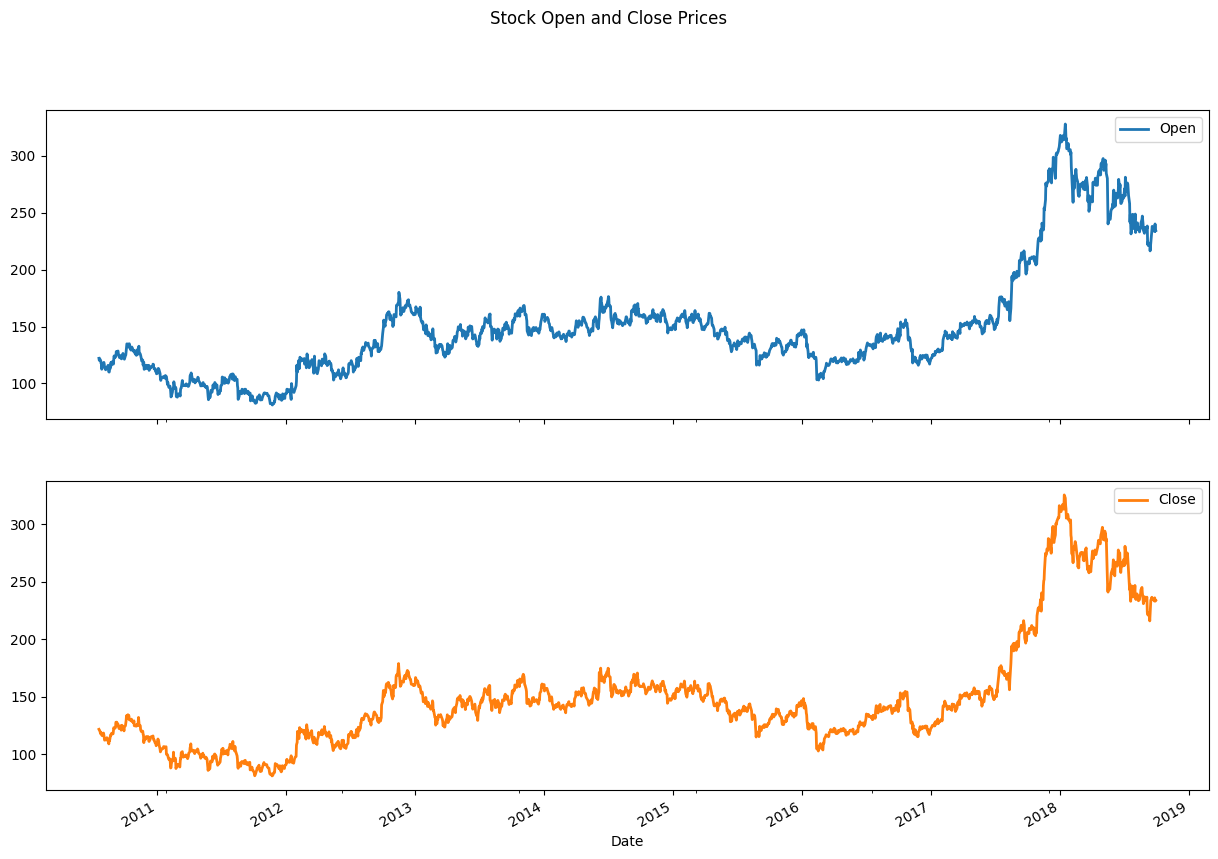

In [11]:
df[['Open', 'Close']].plot(subplots=True, figsize=(15, 10), layout=(2, 1), linewidth=2)
plt.suptitle('Stock Open and Close Prices')
plt.show()


**Candlestick Chart**

In [12]:
# prepare data for candlestick chart
df_candlestick = df[['Open','High','Low','Close']].copy()
df_candlestick.reset_index(inplace=True)
df_candlestick['Date'] = df_candlestick['Date'].map(mdates.date2num)

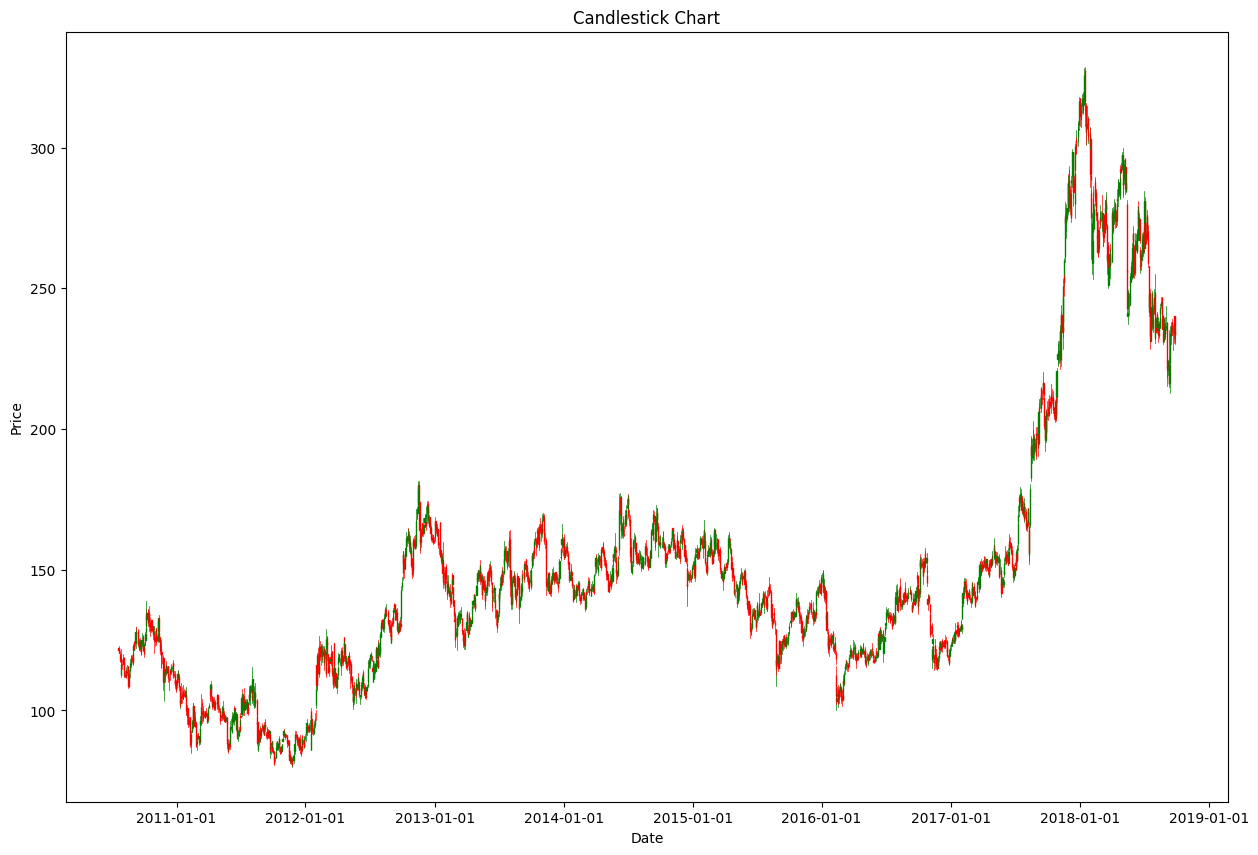

In [13]:
# Plotting candlestick chart
fig, ax = plt.subplots(figsize=(15, 10))
ax.xaxis_date()           # this function tell x_axis it contain dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
candlestick_ohlc(ax, df_candlestick.values, width=0.5, colorup='g', colordown='r')
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

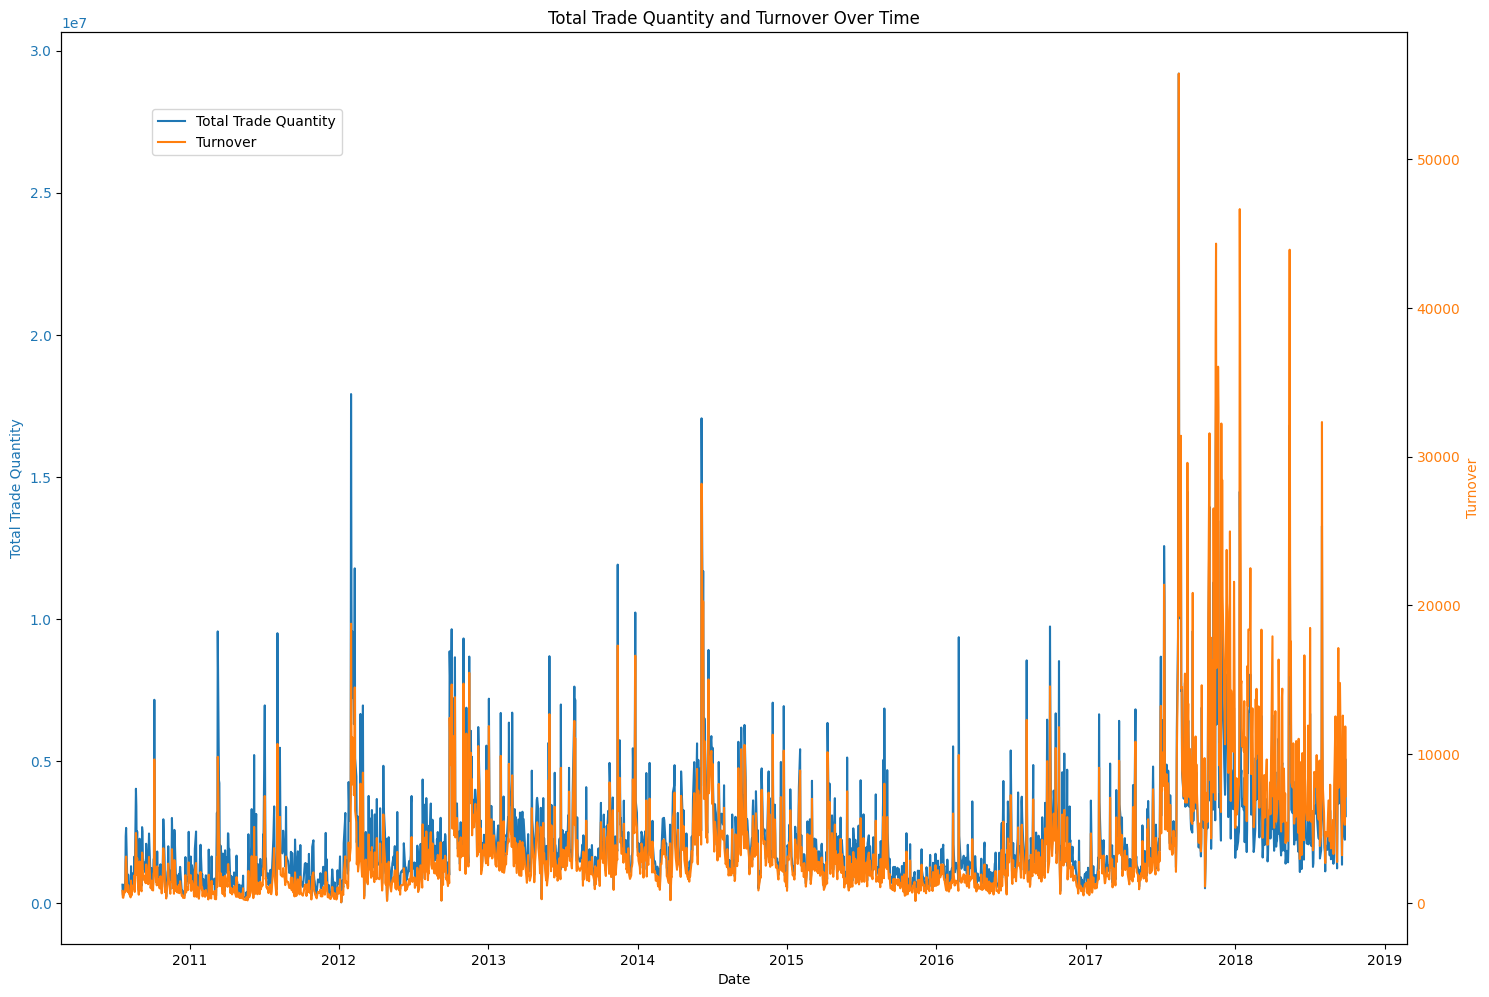

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trade Quantity', color='tab:blue')
ax1.plot(df.index, df['Total Trade Quantity'], color='tab:blue', label='Total Trade Quantity')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Turnover', color='tab:orange')  # we already handled the x-label with ax1
ax2.plot(df.index, df['Turnover (Lacs)'], color='tab:orange', label='Turnover')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Total Trade Quantity and Turnover Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


In [15]:
df1 = df.copy()

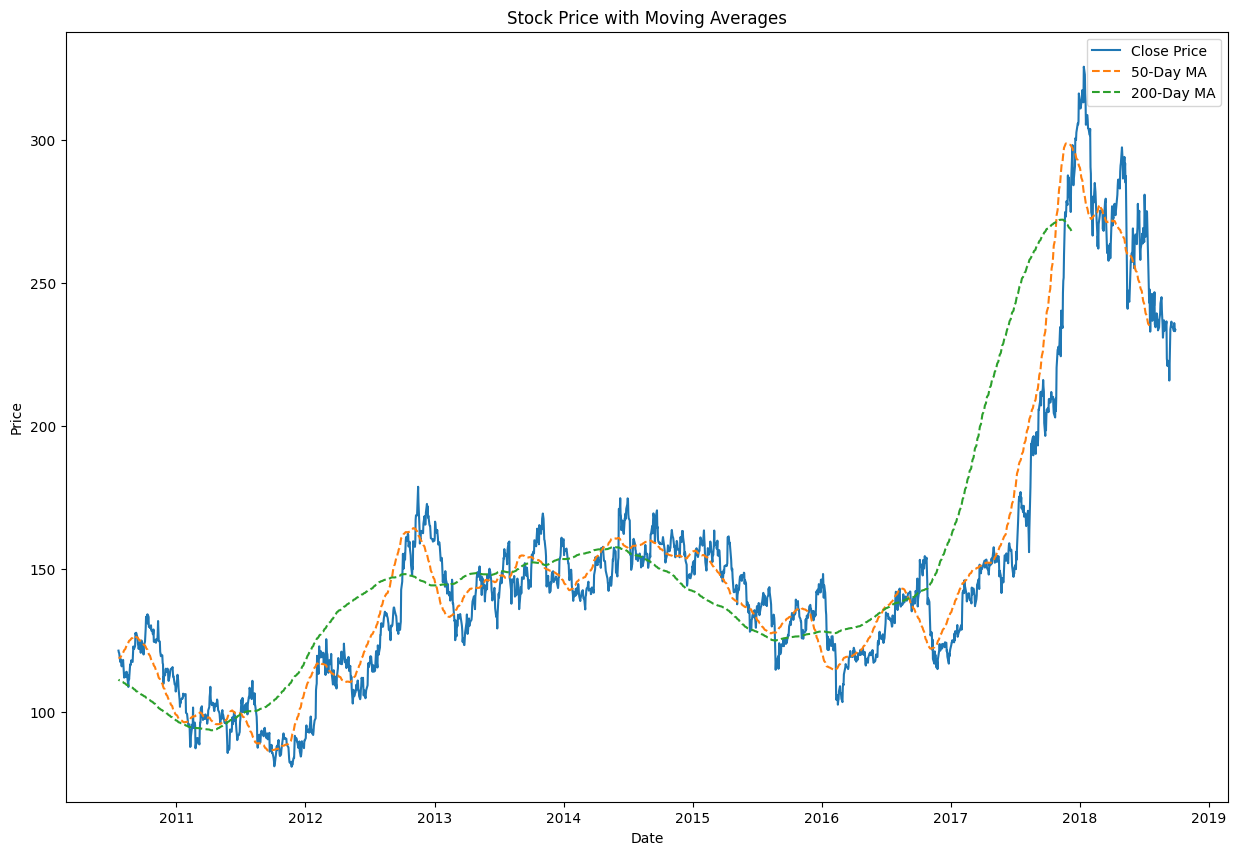

In [16]:
df1['MA50'] = df1['Close'].rolling(window=50).mean()
df1['MA200'] = df1['Close'].rolling(window=200).mean()

plt.figure(figsize=(15, 10))
plt.plot(df.index, df1['Close'], label='Close Price')
plt.plot(df.index, df1['MA50'], label='50-Day MA', linestyle='--')
plt.plot(df.index, df1['MA200'], label='200-Day MA', linestyle='--')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


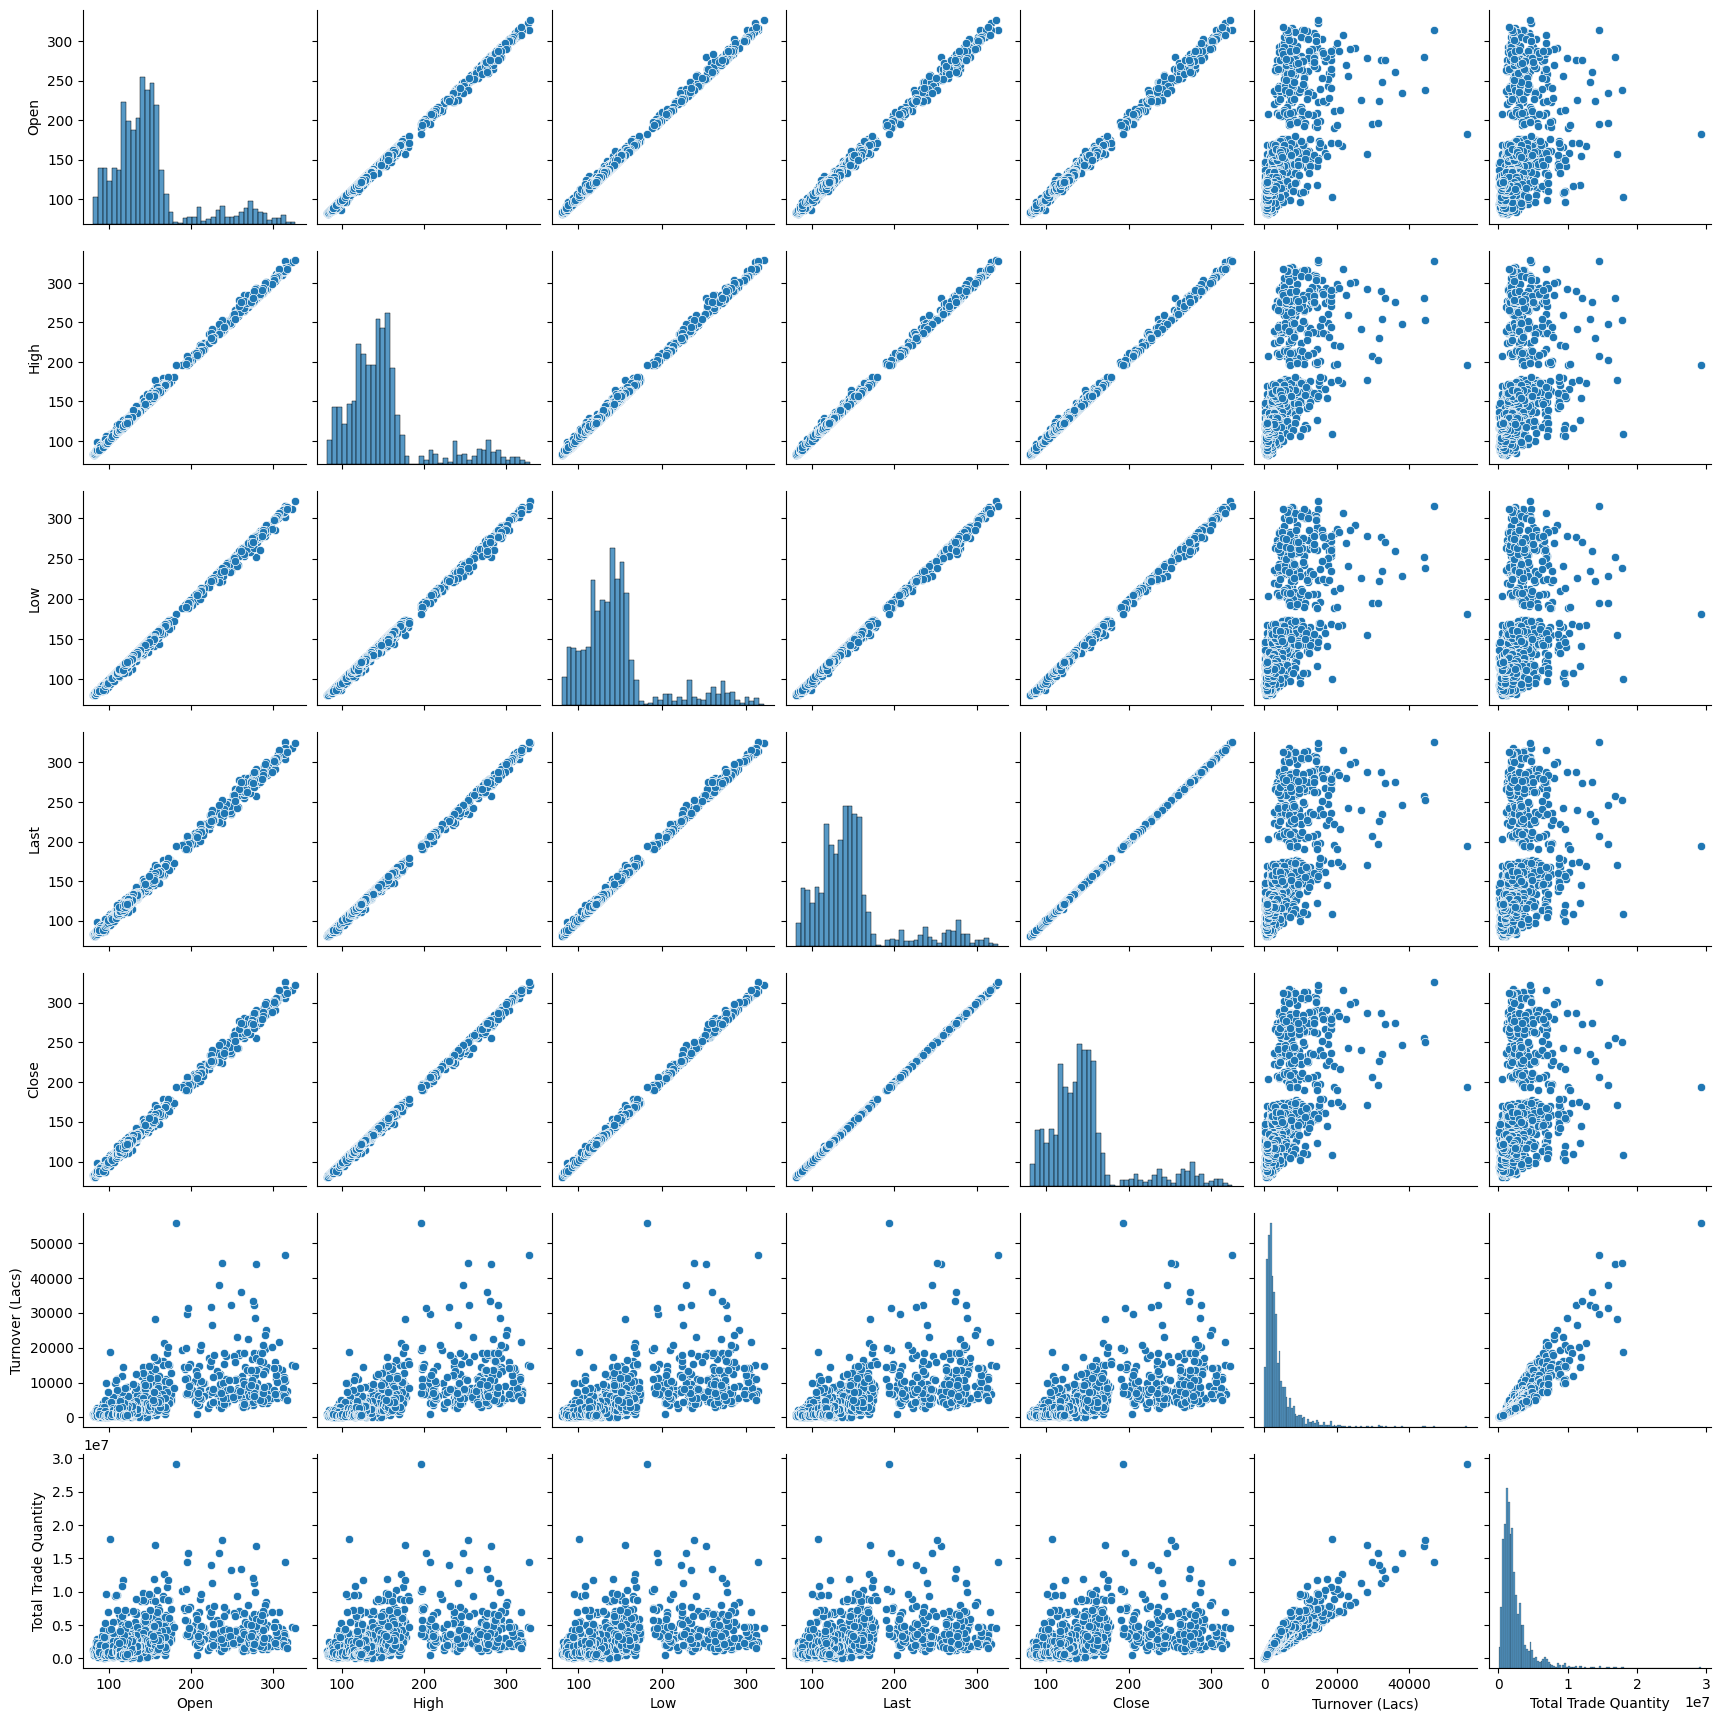

In [17]:
sns.pairplot(df[['Open', 'High', 'Low', 'Last','Close', 'Turnover (Lacs)', 'Total Trade Quantity']])
plt.show()

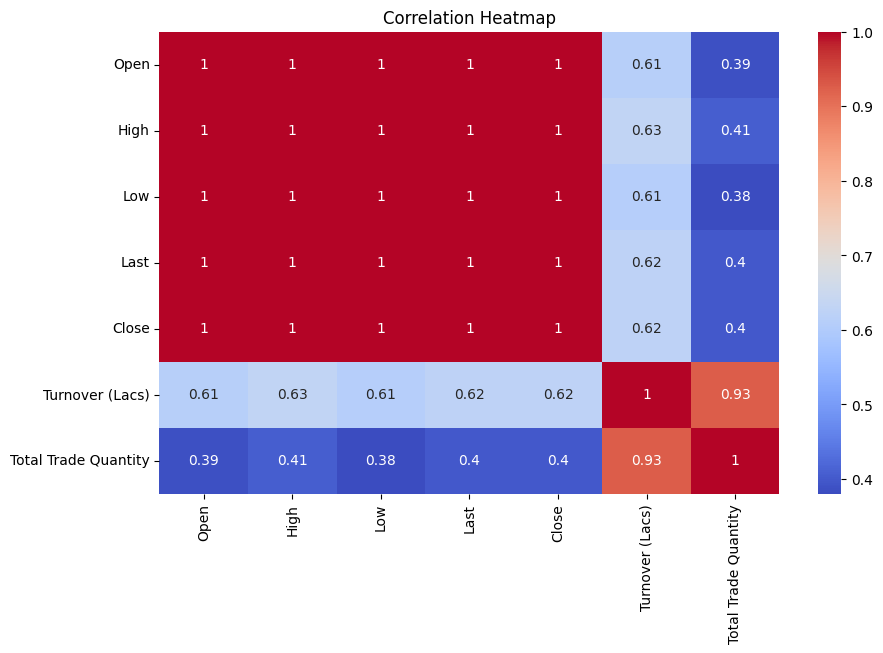

In [18]:
corr = df[['Open', 'High', 'Low', 'Last','Close', 'Turnover (Lacs)', 'Total Trade Quantity']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Shifting Close column to create target varible for next day

In [19]:
df['Target_Close'] = df['Close'].shift(-1)

In [20]:
# Drop the last row as it will have NaN in the target variable
df = df.dropna()

In [21]:
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df.drop(columns=['Target_Close'])), columns=df.drop(columns=['Target_Close']).columns)

In [22]:
# Adding the target column back to the standardized DataFrame
df_standardized['Target_Close'] = df['Target_Close'].values

In [23]:
df_standardized.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Target_Close
0,1.732872,1.698942,1.729520,1.724079,1.730431,0.350670,0.713494,233.25
1,1.743147,1.716146,1.748298,1.730236,1.720166,1.313135,1.741359,234.25
2,1.855147,1.780911,1.777508,1.754862,1.740696,-0.045708,0.294753,236.10
3,1.717459,1.715134,1.767076,1.780514,1.778677,0.006150,0.350615,233.30
4,1.722597,1.764720,1.740995,1.734340,1.721192,0.519737,0.896679,234.60


**Train_Test_Split**

In [24]:
X = df_standardized.drop(['Target_Close', 'Close'], axis=1)
y = df_standardized['Target_Close']

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle = False)

# Print the shapes of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1627, 6)
X_test shape: (407, 6)
y_train shape: (1627,)
y_test shape: (407,)


**Create Sequence For LSTM**

Beacuase LSTM work on Sequential Data

In [26]:
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []  # Xs is an empty list that will store the input sequences.
                     # ys is an empty list that will store the corresponding target values for each sequence.
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps)]
        Xs.append(v)
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

In [27]:
time_steps = 10


X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, time_steps)


print("X_train_seq shape:", X_train_seq.shape)  # (num_samples, time_steps, num_features)
print("y_train_seq shape:", y_train_seq.shape)  # (num_samples,)
print("X_test_seq shape:", X_test_seq.shape)    # (num_samples, time_steps, num_features)
print("y_test_seq shape:", y_test_seq.shape)    # (num_samples,)

X_train_seq shape: (1617, 10, 6)
y_train_seq shape: (1617,)
X_test_seq shape: (397, 10, 6)
y_test_seq shape: (397,)


In [37]:
# Define the hybrid CNN-LSTM model
model = Sequential()

# Convolutional layers to extract features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 6)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# LSTM layers for temporal processing
model.add(RepeatVector(10))  # Repeat the input sequence for LSTM layers
model.add(LSTM(units=120, return_sequences=True, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(units=128, return_sequences=True, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(units=128, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=1))


In [38]:
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8, 64)             1216      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 10, 128)          

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [41]:
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
51/51 [==============================] - 17s 112ms/step - loss: 26991.8945 - val_loss: 11257.7510
Epoch 2/100
51/51 [==============================] - 5s 103ms/step - loss: 26030.5723 - val_loss: 12017.4297
Epoch 3/100
51/51 [==============================] - 4s 76ms/step - loss: 25109.3457 - val_loss: 12447.1924
Epoch 4/100
51/51 [==============================] - 3s 65ms/step - loss: 23966.4199 - val_loss: 13084.1348
Epoch 5/100
51/51 [==============================] - 5s 90ms/step - loss: 22592.8105 - val_loss: 12798.8945
Epoch 6/100
51/51 [==============================] - 4s 76ms/step - loss: 21092.8359 - val_loss: 11394.3350
Epoch 7/100
51/51 [==============================] - 3s 66ms/step - loss: 19213.9023 - val_loss: 10313.4590
Epoch 8/100
51/51 [==============================] - 3s 66ms/step - loss: 17315.1309 - val_loss: 13644.2090
Epoch 9/100
51/51 [==============================] - 5s 100ms/step - loss: 15040.3818 - val_loss: 11515.6006
Epoch 10/100
51/51 [====

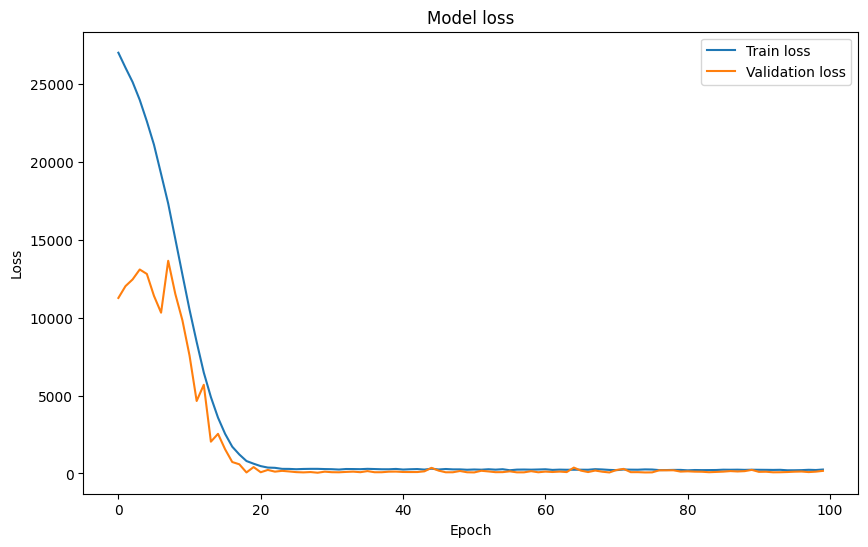

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
y_pred = model.predict(X_test_seq)

13/13 [==============================] - 2s 19ms/step


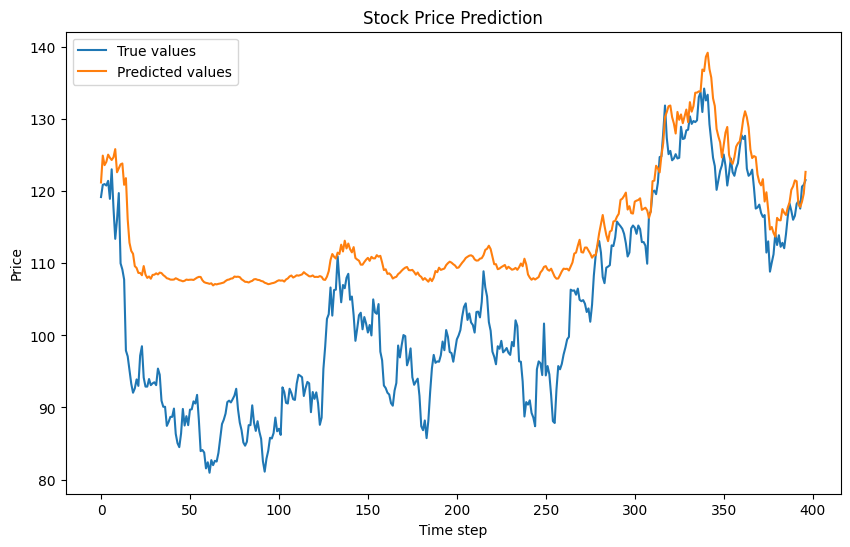

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='True values')
plt.plot(y_pred, label='Predicted values')
plt.title('Stock Price Prediction')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_seq, y_pred)
mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 164.79041744937115
Mean Absolute Error: 10.819854455750894
Root Mean Squared Error: 12.837071996735515
